# Progressive Distillation for Fast Sampling of Diffusion Models
Code and model checkpoints for the <a href="https://openreview.net/forum?id=TIdIXIpzhoI">ICLR 2022 paper</a> by Tim Salimans and Jonathan Ho.

Make sure to use a TPU when running this notebook, enabled via Runtime -> Change runtime type -> Hardware accelerator

<a href="https://colab.research.google.com/github/google-research/google-research/blob/master/diffusion_distillation/diffusion_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**abstract**:
Diffusion models have recently shown great promise for generative modeling, outperforming GANs on perceptual quality and autoregressive models at density estimation. A remaining downside is their slow sampling time: generating high quality samples takes many hundreds or thousands of model evaluations. Here we make two contributions to help eliminate this downside: First, we present new parameterizations of diffusion models that provide increased stability when using few sampling steps. Second, we present a method to distill a trained deterministic diffusion sampler, using many steps, into a new diffusion model that takes half as many sampling steps. We then keep progressively applying this distillation procedure to our model, halving the number of required sampling steps each time. On standard image generation benchmarks like CIFAR-10, ImageNet, and LSUN, we start out with state-of-the-art samplers taking as many as 8192 steps, and are able to distill down to models taking as few as 4 steps without losing much perceptual quality; achieving, for example, a FID of 3.0 on CIFAR-10 in 4 steps. Finally, we show that the full progressive distillation procedure does not take more time than it takes to train the original model, thus representing an efficient solution for generative modeling using diffusion at both train and test time.

This notebook is intended as an easy way to get started with the Progressive Distillation algorithm. Reproducing the results from the paper exactly can be done using the hyperparameters in the provided config files, but this requires running at a larger scale and for longer than is practical in a notebook. Trained model checkpoints are provided and can be loaded with this notebook.

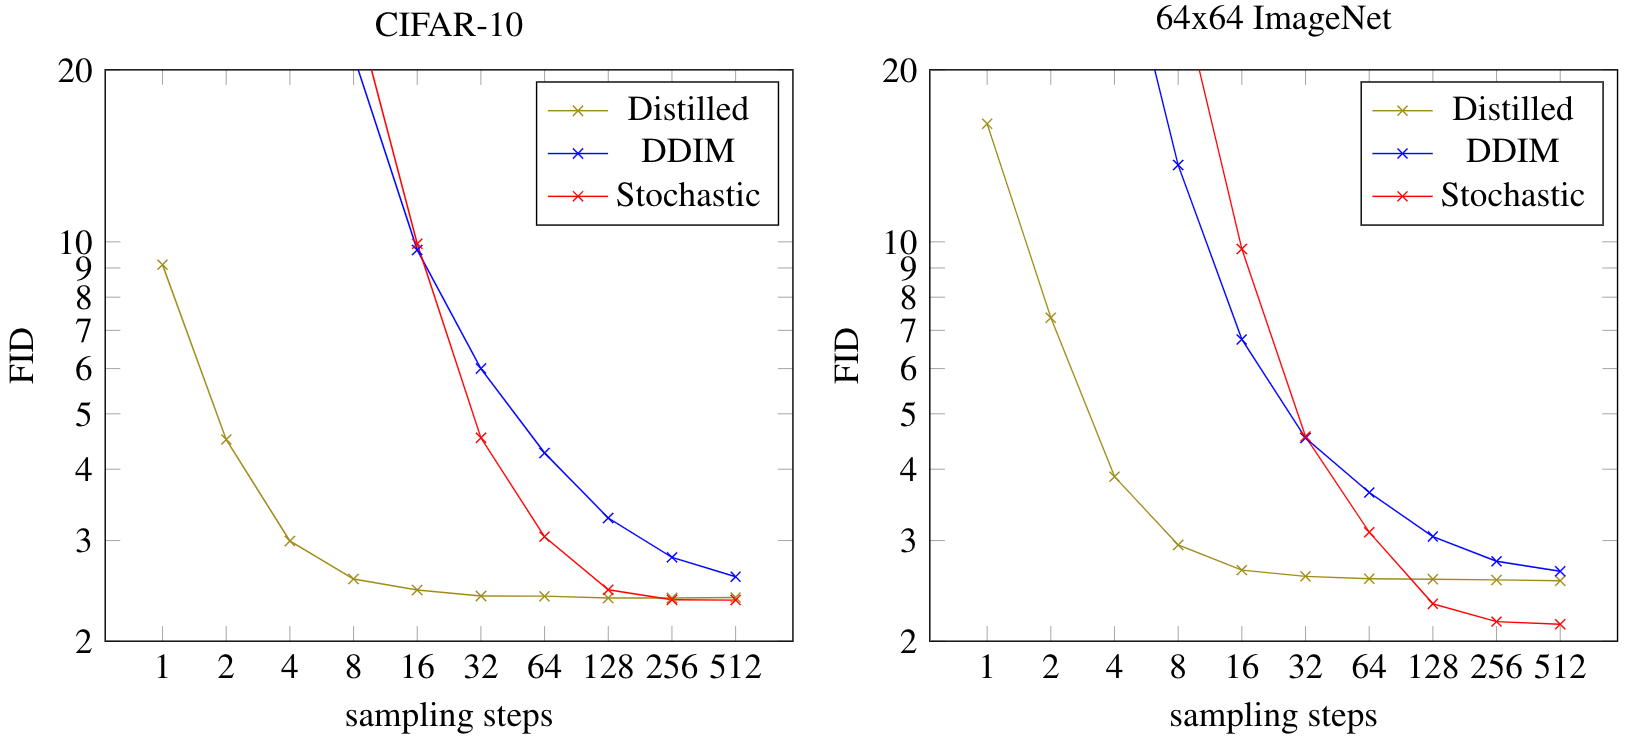

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
# Download the diffusion_distillation repository 
!apt-get -qq install subversion
!svn checkout https://github.com/google-research/google-research/trunk/diffusion_distillation
!pip install -r diffusion_distillation/diffusion_distillation/requirements.txt --quiet

Selecting previously unselected package libapr1:amd64.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../libapr1_1.6.3-2_amd64.deb ...
Unpacking libapr1:amd64 (1.6.3-2) ...
Selecting previously unselected package libaprutil1:amd64.
Preparing to unpack .../libaprutil1_1.6.1-2_amd64.deb ...
Unpacking libaprutil1:amd64 (1.6.1-2) ...
Selecting previously unselected package libserf-1-1:amd64.
Preparing to unpack .../libserf-1-1_1.3.9-6_amd64.deb ...
Unpacking libserf-1-1:amd64 (1.3.9-6) ...
Selecting previously unselected package libsvn1:amd64.
Preparing to unpack .../libsvn1_1.9.7-4ubuntu1_amd64.deb ...
Unpacking libsvn1:amd64 (1.9.7-4ubuntu1) ...
Selecting previously unselected package subversion.
Preparing to unpack .../subversion_1.9.7-4ubuntu1_amd64.deb ...
Unpacking subversion (1.9.7-4ubuntu1) ...
Setting up libapr1:amd64 (1.6.3-2) ...
Setting up libaprutil1:amd64 (1.6.1-2) ...
Setting up libserf-1-1:amd64 (1.3.9-6) ...
Setting up libsvn1

In [2]:
import os
import time
import requests
import functools
import jax
from jax.config import config
import jax.numpy as jnp
import flax
from matplotlib import pyplot as plt
import numpy as onp
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
from diffusion_distillation import diffusion_distillation

In [3]:
# configure JAX to use the TPU
if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  time.sleep(5)
  TPU_DRIVER_MODE = 1
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target) 

grpc://10.13.106.178:8470


## Train a new diffusion model

In [ ]:
# create model
config = diffusion_distillation.config.cifar_base.get_config()
model = diffusion_distillation.model.Model(config)

In [ ]:
# init params 
state = jax.device_get(model.make_init_state())
state = flax.jax_utils.replicate(state)

In [ ]:
# JIT compile training step
train_step = functools.partial(model.step_fn, jax.random.PRNGKey(0), True)
train_step = functools.partial(jax.lax.scan, train_step)  # for substeps
train_step = jax.pmap(train_step, axis_name='batch', donate_argnums=(0,))

In [ ]:
# build input pipeline
total_bs = config.train.batch_size
device_bs = total_bs // jax.device_count()
train_ds = model.dataset.get_shuffled_repeated_dataset(
    split='train',
    batch_shape=(
        jax.local_device_count(),  # for pmap
        config.train.substeps,  # for lax.scan over multiple substeps
        device_bs,  # batch size per device
    ),
    local_rng=jax.random.PRNGKey(0),
    augment=True)
train_iter = diffusion_distillation.utils.numpy_iter(train_ds)

In [ ]:
# run training
for step in range(10):
  batch = next(train_iter)
  state, metrics = train_step(state, batch)
  metrics = jax.device_get(flax.jax_utils.unreplicate(metrics))
  metrics = jax.tree_map(lambda x: float(x.mean(axis=0)), metrics)
  print(metrics)

{'train/gnorm': 1.464990258216858, 'train/loss': 0.3968523442745209}
{'train/gnorm': 1.0451922416687012, 'train/loss': 0.23701481521129608}
{'train/gnorm': 1.3321584463119507, 'train/loss': 0.1849556267261505}
{'train/gnorm': 0.8692127466201782, 'train/loss': 0.15539495646953583}
{'train/gnorm': 0.8343032598495483, 'train/loss': 0.15620359778404236}
{'train/gnorm': 0.7462563514709473, 'train/loss': 0.13796086609363556}
{'train/gnorm': 0.8287917971611023, 'train/loss': 0.14854209125041962}
{'train/gnorm': 0.6603997945785522, 'train/loss': 0.13255183398723602}
{'train/gnorm': 0.8660920262336731, 'train/loss': 0.1383683979511261}
{'train/gnorm': 0.6390635371208191, 'train/loss': 0.12706886231899261}


## Distill a trained diffusion model

In [ ]:
# create model
config = diffusion_distillation.config.cifar_distill.get_config()
model = diffusion_distillation.model.Model(config)

In [ ]:
# load the teacher params
model.load_teacher_state(config.distillation.teacher_checkpoint_path)

loading from local copy of GCS file: /temp/download/gresearch/diffusion-distillation/cifar_original


In [ ]:
# init student state
init_params = diffusion_distillation.utils.copy_pytree(model.teacher_state.ema_params)
optim = model.make_optimizer_def().create(init_params)
state = diffusion_distillation.model.TrainState(
    step=model.teacher_state.step,
    optimizer=optim,
    ema_params=diffusion_distillation.utils.copy_pytree(init_params),
    num_sample_steps=model.teacher_state.num_sample_steps//2)

In [ ]:
# build input pipeline
total_bs = config.train.batch_size
device_bs = total_bs // jax.device_count()
train_ds = model.dataset.get_shuffled_repeated_dataset(
    split='train',
    batch_shape=(
        jax.local_device_count(),  # for pmap
        config.train.substeps,  # for lax.scan over multiple substeps
        device_bs,  # batch size per device
    ),
    local_rng=jax.random.PRNGKey(0),
    augment=True)
train_iter = diffusion_distillation.utils.numpy_iter(train_ds)

In [ ]:
steps_per_distill_iter = 10  # number of distillation steps per iteration of progressive distillation
end_num_steps = 4  # eventual number of sampling steps we want to use 
while state.num_sample_steps >= end_num_steps:

  # compile training step
  train_step = functools.partial(model.step_fn, jax.random.PRNGKey(0), True)
  train_step = functools.partial(jax.lax.scan, train_step)  # for substeps
  train_step = jax.pmap(train_step, axis_name='batch', donate_argnums=(0,))

  # train the student against the teacher model
  print('distilling teacher using %d sampling steps into student using %d steps'
        % (model.teacher_state.num_sample_steps, state.num_sample_steps))
  state = flax.jax_utils.replicate(state)
  for step in range(steps_per_distill_iter):
    batch = next(train_iter)
    state, metrics = train_step(state, batch)
    metrics = jax.device_get(flax.jax_utils.unreplicate(metrics))
    metrics = jax.tree_map(lambda x: float(x.mean(axis=0)), metrics)
    print(metrics)

  # student becomes new teacher for next distillation iteration
  model.teacher_state = jax.device_get(
      flax.jax_utils.unreplicate(state).replace(optimizer=None))

  # reset student optimizer for next distillation iteration
  init_params = diffusion_distillation.utils.copy_pytree(model.teacher_state.ema_params)
  optim = model.make_optimizer_def().create(init_params)
  state = diffusion_distillation.model.TrainState(
      step=model.teacher_state.step,
      optimizer=optim,
      ema_params=diffusion_distillation.utils.copy_pytree(init_params),
      num_sample_steps=model.teacher_state.num_sample_steps//2)

distilling teacher using 8192 sampling steps into student using 4096 steps
{'train/gnorm': 2.8683674335479736, 'train/loss': 0.0016302959993481636}
{'train/gnorm': 0.2860860824584961, 'train/loss': 0.00021573054254986346}
{'train/gnorm': 0.2714298367500305, 'train/loss': 0.0002000583044718951}
{'train/gnorm': 0.21906311810016632, 'train/loss': 0.00011645098129520193}
{'train/gnorm': 6.853092193603516, 'train/loss': 0.003547081258147955}
{'train/gnorm': 0.1784321814775467, 'train/loss': 0.00012405704183038324}
{'train/gnorm': 6.246722221374512, 'train/loss': 0.003840960096567869}
{'train/gnorm': 0.6847068071365356, 'train/loss': 0.00032937084324657917}
{'train/gnorm': 1.5631742477416992, 'train/loss': 0.0009624079684726894}
{'train/gnorm': 0.5180217623710632, 'train/loss': 0.00028331097564660013}
distilling teacher using 4096 sampling steps into student using 2048 steps
{'train/gnorm': 2.5235648155212402, 'train/loss': 0.0019040238112211227}
{'train/gnorm': 2.9192070960998535, 'train/lo

## Load a distilled model checkpoint and sample from it

In [4]:
# list all available distilled checkpoints
!gsutil ls gs://gresearch/diffusion-distillation

gs://gresearch/diffusion-distillation/bedroom_1
gs://gresearch/diffusion-distillation/bedroom_16
gs://gresearch/diffusion-distillation/bedroom_2
gs://gresearch/diffusion-distillation/bedroom_32
gs://gresearch/diffusion-distillation/bedroom_4
gs://gresearch/diffusion-distillation/bedroom_64
gs://gresearch/diffusion-distillation/bedroom_8
gs://gresearch/diffusion-distillation/bedroom_original
gs://gresearch/diffusion-distillation/church_1
gs://gresearch/diffusion-distillation/church_16
gs://gresearch/diffusion-distillation/church_2
gs://gresearch/diffusion-distillation/church_32
gs://gresearch/diffusion-distillation/church_4
gs://gresearch/diffusion-distillation/church_64
gs://gresearch/diffusion-distillation/church_8
gs://gresearch/diffusion-distillation/church_original
gs://gresearch/diffusion-distillation/cifar_1
gs://gresearch/diffusion-distillation/cifar_16
gs://gresearch/diffusion-distillation/cifar_2
gs://gresearch/diffusion-distillation/cifar_32
gs://gresearch/diffusion-distillat

In [6]:
# create imagenet model
config = diffusion_distillation.config.imagenet64_base.get_config()
model = diffusion_distillation.model.Model(config)

In [7]:
# load distilled checkpoint for 8 sampling steps
loaded_params = diffusion_distillation.checkpoints.restore_from_path('gs://gresearch/diffusion-distillation/imagenet_8', target=None)['ema_params']

downloading file from GCS: gs://gresearch/diffusion-distillation/imagenet_8


In [8]:
# fix possible flax version errors
ema_params = jax.device_get(model.make_init_state()).ema_params
loaded_params = flax.core.unfreeze(loaded_params)
loaded_params = jax.tree_map(
    lambda x, y: onp.reshape(x, y.shape) if hasattr(y, 'shape') else x,
    loaded_params,
    flax.core.unfreeze(ema_params))
loaded_params = flax.core.freeze(loaded_params)
del ema_params

In [15]:
# sample from the model
imagenet_classes = {'malamute': 249, 'siamese': 284, 'great_white': 2,
                    'speedboat': 814, 'reef': 973, 'sports_car': 817,
                    'race_car': 751, 'model_t': 661, 'truck': 867}
labels = imagenet_classes['truck'] * jnp.ones((4,), dtype=jnp.int32)
samples = model.samples_fn(rng=jax.random.PRNGKey(0), labels=labels, params=loaded_params, num_steps=8)
samples = jax.device_get(samples).astype(onp.uint8)

(-0.5, 131.5, 131.5, -0.5)

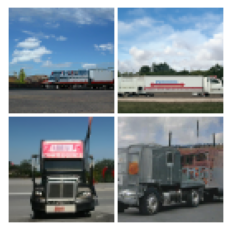

In [16]:
# visualize samples
padded_samples = onp.pad(samples, ((0,0), (1,1), (1,1), (0,0)), mode='constant', constant_values=255)
nrows = int(onp.sqrt(padded_samples.shape[0]))
ncols = padded_samples.shape[0]//nrows
_, height, width, channels = padded_samples.shape
img_grid = padded_samples.reshape(nrows, ncols, height, width, channels).swapaxes(1,2).reshape(height*nrows, width*ncols, channels)
img = plt.imshow(img_grid)
plt.axis('off')